In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install cityscapesscripts

In [1]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive

import os
import cv2
import glob
import pickle
import numpy as np
import tensorflow as tf
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, BatchNormalization, ReLU, LeakyReLU, Concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Add
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from google.colab import files
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import MeanIoU
import sklearn.metrics as skm

In [ ]:
from cityscapesscripts.download import downloader
session = downloader.login()
downloader.get_available_packages(session=session)
package_list =['gtFine_trainvaltest.zip', 'leftImg8bit_trainvaltest.zip']
downloader.download_packages(session=session, package_names=package_list, destination_path='/content/drive/MyDrive/Cityscapes')

Cityscapes username or email address: rahulgg
Cityscapes password: ··········
Store credentials unencrypted in '/root/.local/share/cityscapesscripts/credentials.json' [y/N]: y


Download progress: 100%|█████████▉| 241M/241M [00:09<00:00, 25.7MB/s]


Download progress:  98%|█████████▊| 10.8G/11.0G [07:09<00:08, 27.0MB/s]


In [2]:
!mkdir data

In [3]:
import os
base_dir='content/data'
folder1 = os.path.join(base_dir, 'gtFine')
folder2 = os.path.join(base_dir, 'leftImg8bit')

os.makedirs(folder1, exist_ok=True)
os.makedirs(folder2, exist_ok=True)


In [2]:
#!unzip '/content/drive/MyDrive/Cityscapes/gtFine_trainvaltest.zip' -d /content/content/data/gtFine

In [1]:
#!unzip '/content/drive/MyDrive/Cityscapes/leftImg8bit_trainvaltest.zip' -d /content/content/data/leftImg8bit

In [10]:
# Directory setup
from tensorflow.keras.preprocessing.image import load_img, img_to_array
data_dir = "/content/content/data"
images_dir = os.path.join(data_dir, "leftImg8bit/leftImg8bit")
masks_dir = os.path.join(data_dir, "gtFine/gtFine")

In [11]:
ignore_index = 255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light',
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus',
               'train', 'motorcycle', 'bicycle']

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes = len(valid_classes)

colors = [
    [0, 0, 0], [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153], [153, 153, 153],
    [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152], [0, 130, 180], [220, 20, 60], [255, 0, 0],
    [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32],
]

label_colours = dict(zip(range(n_classes), colors))

In [12]:

def encode_segmap(mask):
    mask = np.array(mask, dtype=np.int32)
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    mask[mask == ignore_index] = len(valid_classes) 
    return mask


def decode_segmap(temp):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r
    rgb[:, :, 1] = g
    rgb[:, :, 2] = b
    return rgb

In [13]:

def get_image_paths(images_dir, masks_dir, subset):
    image_files = []
    mask_files = []

    for root, _, files in os.walk(os.path.join(images_dir, subset)):
        for file in files:
            if file.endswith('_leftImg8bit.png'):
                image_files.append(os.path.join(root, file))

    for root, _, files in os.walk(os.path.join(masks_dir, subset)):
        for file in files:
            if file.endswith('_gtFine_labelIds.png'):
                mask_files.append(os.path.join(root, file))

    return sorted(image_files), sorted(mask_files)


def create_subset_dataset(images_dir, masks_dir, subset, batch_size=8):
    image_paths, mask_paths = get_image_paths(images_dir, masks_dir, subset)

    
    print(f"Found {len(image_paths)} {subset} images")
    print(f"Found {len(mask_paths)} {subset} masks")

    def load_and_preprocess_image(image_path, mask_path, img_size=(256, 512)):
        image = load_img(image_path, target_size=img_size)
        mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')

        image = img_to_array(image)
        mask = img_to_array(mask)

        image = image / 255.0  
        
        mask = np.squeeze(mask).astype(np.int32)
        mask = encode_segmap(mask)  # Encode the mask

        # Debugging: Check unique values in mask
        # print(f"Unique values in mask before encoding: {np.unique(np.squeeze(mask))}")
        # print(f"Unique values in mask after encoding: {np.unique(mask)}")

        return image, mask

    def process_path(image_path, mask_path):
        image, mask = tf.numpy_function(
            load_and_preprocess_image, [image_path, mask_path], [tf.float32, tf.int32])
        mask.set_shape([None, None])  
        return image, mask

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Create TensorFlow datasets for each subset
train_dataset = create_subset_dataset(images_dir, masks_dir, 'train')
val_dataset = create_subset_dataset(images_dir, masks_dir, 'val')
test_dataset = create_subset_dataset(images_dir, masks_dir, 'test')

Found 2975 train images
Found 2975 train masks
Found 500 val images
Found 500 val masks
Found 1525 test images
Found 1525 test masks


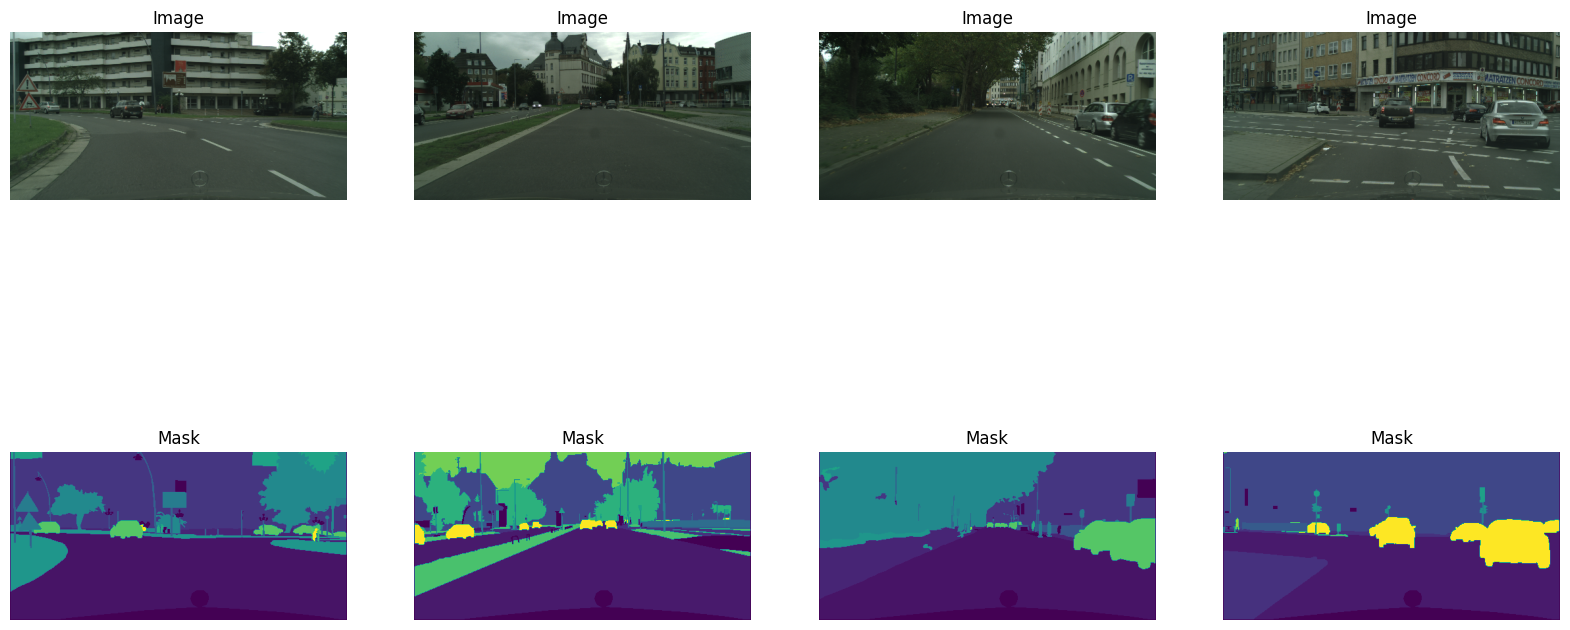

In [14]:
def plot_images_masks(images, masks, n=4):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title('Image')

        plt.subplot(2, n, n+i+1)
        plt.imshow(masks[i])
        plt.axis('off')
        plt.title('Mask')

    plt.show()

for images, masks in train_dataset.take(1):
    plot_images_masks(images.numpy(), masks.numpy())

In [41]:
def DeeplabV3Plus(input_shape=(256, 512, 3), num_classes=19):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    image_features = base_model.get_layer('conv4_block6_2_relu').output

    # Atrous Spatial Pyramid Pooling
    b0 = Conv2D(256, (1, 1), padding='same')(image_features)
    b0 = BatchNormalization()(b0)
    b0 = Activation('relu')(b0)

    b1 = Conv2D(256, (3, 3), padding='same', dilation_rate=6)(image_features)
    b1 = BatchNormalization()(b1)
    b1 = Activation('relu')(b1)

    b2 = Conv2D(256, (3, 3), padding='same', dilation_rate=12)(image_features)
    b2 = BatchNormalization()(b2)
    b2 = Activation('relu')(b2)

    b3 = Conv2D(256, (3, 3), padding='same', dilation_rate=18)(image_features)
    b3 = BatchNormalization()(b3)
    b3 = Activation('relu')(b3)

    x = Concatenate()([b0, b1, b2, b3])

    x = Conv2D(256, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Decoder
    x = UpSampling2D((4, 4), interpolation='bilinear')(x)
    x = Concatenate()([x, base_model.get_layer('conv2_block3_out').output])

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D((4, 4), interpolation='bilinear')(x)
    x = Conv2D(num_classes, (1, 1), padding='same')(x)
    x = Activation('softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

In [42]:
model = DeeplabV3Plus(input_shape=(256, 512, 3), num_classes=n_classes)

# weights_path = '/content/drive/MyDrive/segprooject.h5'

# model.load_weights(weights_path)

In [47]:
import tensorflow as tf

def boundary_loss(y_true, y_pred):
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)

    y_true_edges = tf.image.sobel_edges(tf.cast(y_true, tf.float32))
    y_pred_edges = tf.image.sobel_edges(tf.cast(y_pred, tf.float32))

    return tf.reduce_mean(tf.square(y_true_edges - y_pred_edges))

def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    ba_loss = boundary_loss(y_true, y_pred)
    return ce_loss + 0.5 * ba_loss

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=combined_loss,
              metrics=['accuracy'])


In [48]:
checkpoint = ModelCheckpoint('best_model1.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [49]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10,
                    callbacks=callbacks)

Epoch 1/10
372/372 [==============================] - ETA: 0s - loss: 22.3482 - accuracy: 0.8127
Epoch 1: val_loss improved from inf to 22.69729, saving model to best_model1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


372/372 [==============================] - 441s 1s/step - loss: 22.3482 - accuracy: 0.8127 - val_loss: 22.6973 - val_accuracy: 0.4110 - lr: 1.0000e-04
Epoch 2/10
372/372 [==============================] - ETA: 0s - loss: 18.6031 - accuracy: 0.8670
Epoch 2: val_loss did not improve from 22.69729
372/372 [==============================] - 381s 1s/step - loss: 18.6031 - accuracy: 0.8670 - val_loss: 22.9132 - val_accuracy: 0.6920 - lr: 1.0000e-04
Epoch 3/10
372/372 [==============================] - ETA: 0s - loss: 17.7165 - accuracy: 0.8910
Epoch 3: val_loss improved from 22.69729 to 20.43302, saving model to best_model1.h5
372/372 [==============================] - 383s 1s/step - loss: 17.7165 - accuracy: 0.8910 - val_loss: 20.4330 - val_accuracy: 0.8463 - lr: 1.0000e-04
Epoch 4/10
372/372 [==============================] - ETA: 0s - loss: 17.0131 - accuracy: 0.9086
Epoch 4: val_loss improved from 20.43302 to 20.04889, saving model to best_model1.h5
372/372 [=============================

In [50]:
from google.colab import files
files.download('best_model1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CRF (Conditional Random Field) Trial

In [57]:
#pip install git+https://github.com/lucasb-eyer/pydensecrf.git

1/1 [==============================] - 0s 58ms/step


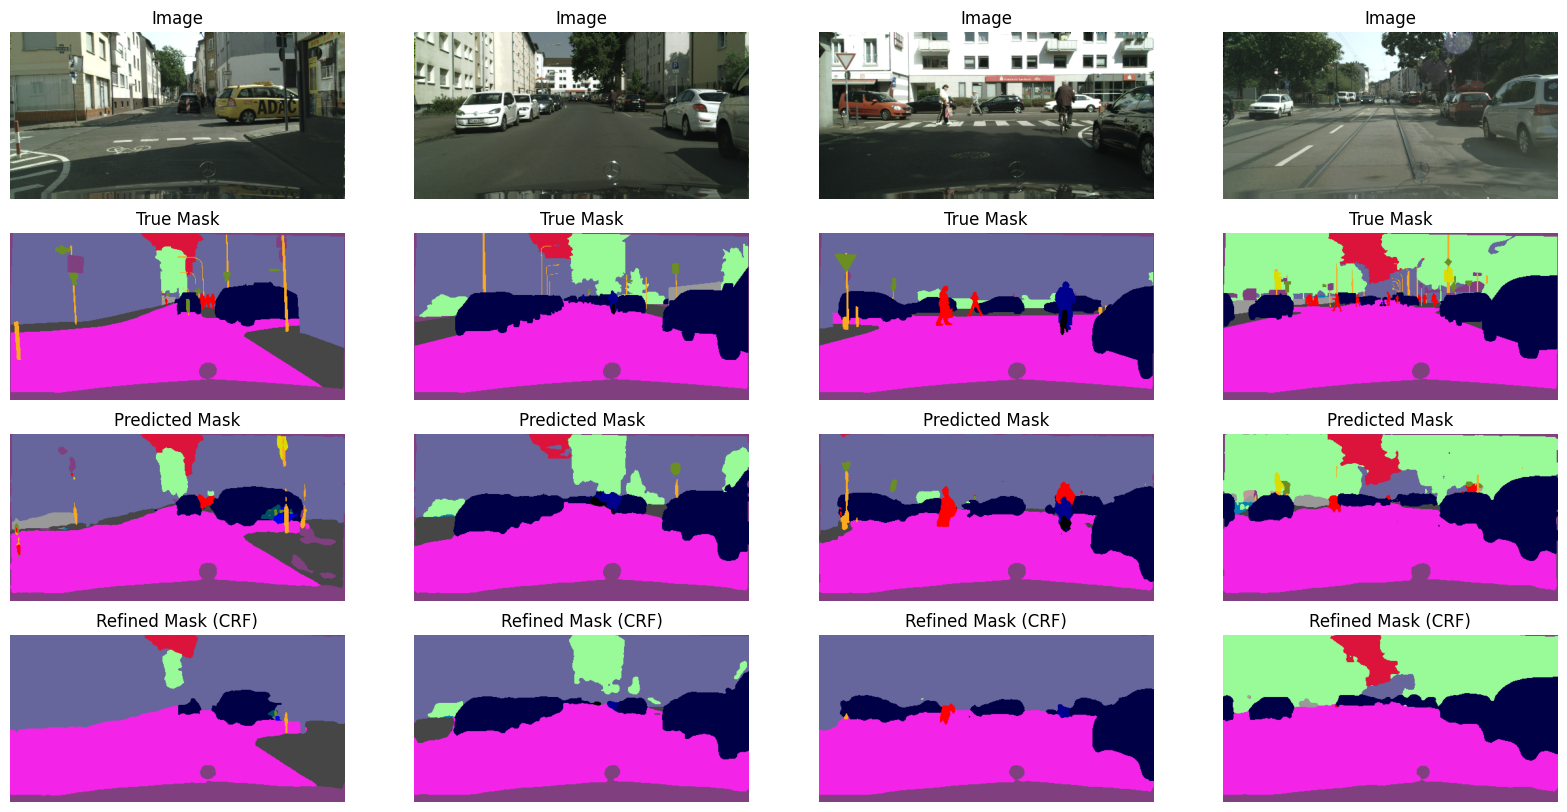

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral, create_pairwise_gaussian

# Existing functions (encode_segmap, decode_segmap, get_image_paths, create_subset_dataset, plot_images_masks, etc.)

def crf_post_processing(image, predicted_probabilities,
                        n_iterations=50, sxy_gaussian=(3, 3), sxy_bilateral=(50, 50),
                        srgb_bilateral=(13, 13, 13), compat_gaussian=3, compat_bilateral=10):
    h, w = predicted_probabilities.shape[:2]
    n_classes = predicted_probabilities.shape[-1]

    unary = unary_from_softmax(predicted_probabilities.transpose(2, 0, 1))
    unary = np.ascontiguousarray(unary)
    d = dcrf.DenseCRF2D(w, h, n_classes)

    d.setUnaryEnergy(unary)

    # Create pairwise potentials
    feats = create_pairwise_gaussian(sdims=sxy_gaussian, shape=(w, h))
    d.addPairwiseEnergy(feats, compat=compat_gaussian, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    feats = create_pairwise_bilateral(sdims=sxy_bilateral, schan=srgb_bilateral, img=image, chdim=2)
    feats = np.ascontiguousarray(feats)
    d.addPairwiseEnergy(feats, compat=compat_bilateral, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # Perform CRF inference
    refined_predictions = d.inference(n_iterations)
    refined_predictions = np.array(refined_predictions).reshape((n_classes, h, w)).transpose(1, 2, 0)

    return refined_predictions

def plot_predictions_with_crf(model, dataset, colormap, num_images=4, crf_params=None):
    if crf_params is None:
        crf_params = {
            "n_iterations": 50,
            "sxy_gaussian": (3, 3),
            "sxy_bilateral": (50, 50),
            "srgb_bilateral": (13, 13, 13),
            "compat_gaussian": 3,
            "compat_bilateral": 10
        }

    dataset_iter = iter(dataset)
    images, masks = next(dataset_iter)
    predictions = model.predict(images)

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        image = images[i].numpy()

        # Plot original image
        plt.subplot(4, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Image')

        # Plot true mask in color
        true_mask = np.squeeze(masks[i].numpy())
        true_mask_rgb = decode_segmentation_mask(true_mask, colormap)
        plt.subplot(4, num_images, num_images + i + 1)
        plt.imshow(true_mask_rgb)
        plt.axis('off')
        plt.title('True Mask')

        # Plot predicted mask in color
        pred_mask = np.argmax(predictions[i], axis=-1)
        pred_mask_rgb = decode_segmentation_mask(pred_mask, colormap)
        plt.subplot(4, num_images, 2 * num_images + i + 1)
        plt.imshow(pred_mask_rgb)
        plt.axis('off')
        plt.title('Predicted Mask')

        # Apply CRF and plot the refined mask
        refined_predictions = crf_post_processing(image, predictions[i], **crf_params)
        refined_mask = np.argmax(refined_predictions, axis=-1)
        refined_mask_rgb = decode_segmentation_mask(refined_mask, colormap)
        plt.subplot(4, num_images, 3 * num_images + i + 1)
        plt.imshow(refined_mask_rgb)
        plt.axis('off')
        plt.title('Refined Mask (CRF)')

    plt.show()

# Example usage with custom CRF parameters
crf_params = {
    "n_iterations": 10,
    "sxy_gaussian": (3, 3),
    "sxy_bilateral": (50, 50),
    "srgb_bilateral": (13, 13, 13),
    "compat_gaussian": 3,
    "compat_bilateral": 10
}

# Plot predictions with CRF on validation dataset with custom parameters
plot_predictions_with_crf(model, val_dataset, colormap, num_images=4, crf_params=crf_params)



Accuracy and Loss Plots

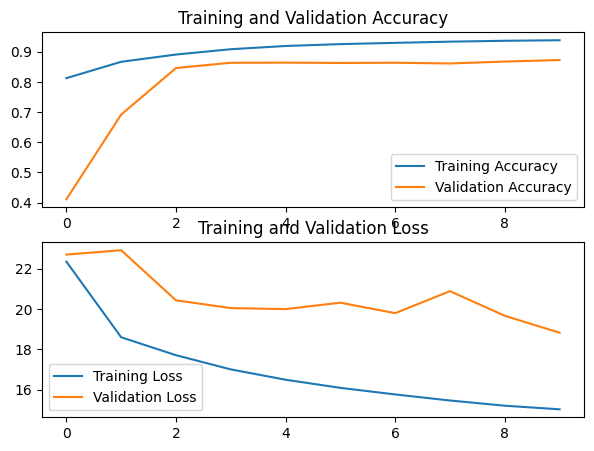

In [51]:

def plot_training_history(history, save_path=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = history.epoch

    plt.figure(figsize=(7, 5))

    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Loss')

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f'Saving figure to: {save_path}')

    plt.show()
plot_training_history(history)

Output Visualization 

In [52]:
def create_cityscapes_colormap():
    colormap = np.zeros((19, 3), dtype=int)
    colormap[0] = [128, 64, 128]   # road
    colormap[1] = [244, 35, 232]   # sidewalk
    colormap[2] = [70, 70, 70]     # building
    colormap[3] = [102, 102, 156]  # wall
    colormap[4] = [190, 153, 153]  # fence
    colormap[5] = [153, 153, 153]  # pole
    colormap[6] = [250, 170, 30]   # traffic light
    colormap[7] = [220, 220, 0]    # traffic sign
    colormap[8] = [107, 142, 35]   # vegetation
    colormap[9] = [152, 251, 152]  # terrain
    colormap[10] = [0, 130, 180]   # sky
    colormap[11] = [220, 20, 60]   # person
    colormap[12] = [255, 0, 0]     # rider
    colormap[13] = [0, 0, 142]     # car
    colormap[14] = [0, 0, 70]      # truck
    colormap[15] = [0, 60, 100]    # bus
    colormap[16] = [0, 80, 100]    # train
    colormap[17] = [0, 0, 230]     # motorcycle
    colormap[18] = [119, 11, 32]   # bicycle
    return colormap

colormap = create_cityscapes_colormap()

In [53]:
def decode_segmentation_mask(mask, colormap):
    """Convert a grayscale mask to an RGB color mask."""
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, len(colormap)):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

Colored Prediction

1/1 [==============================] - 3s 3s/step


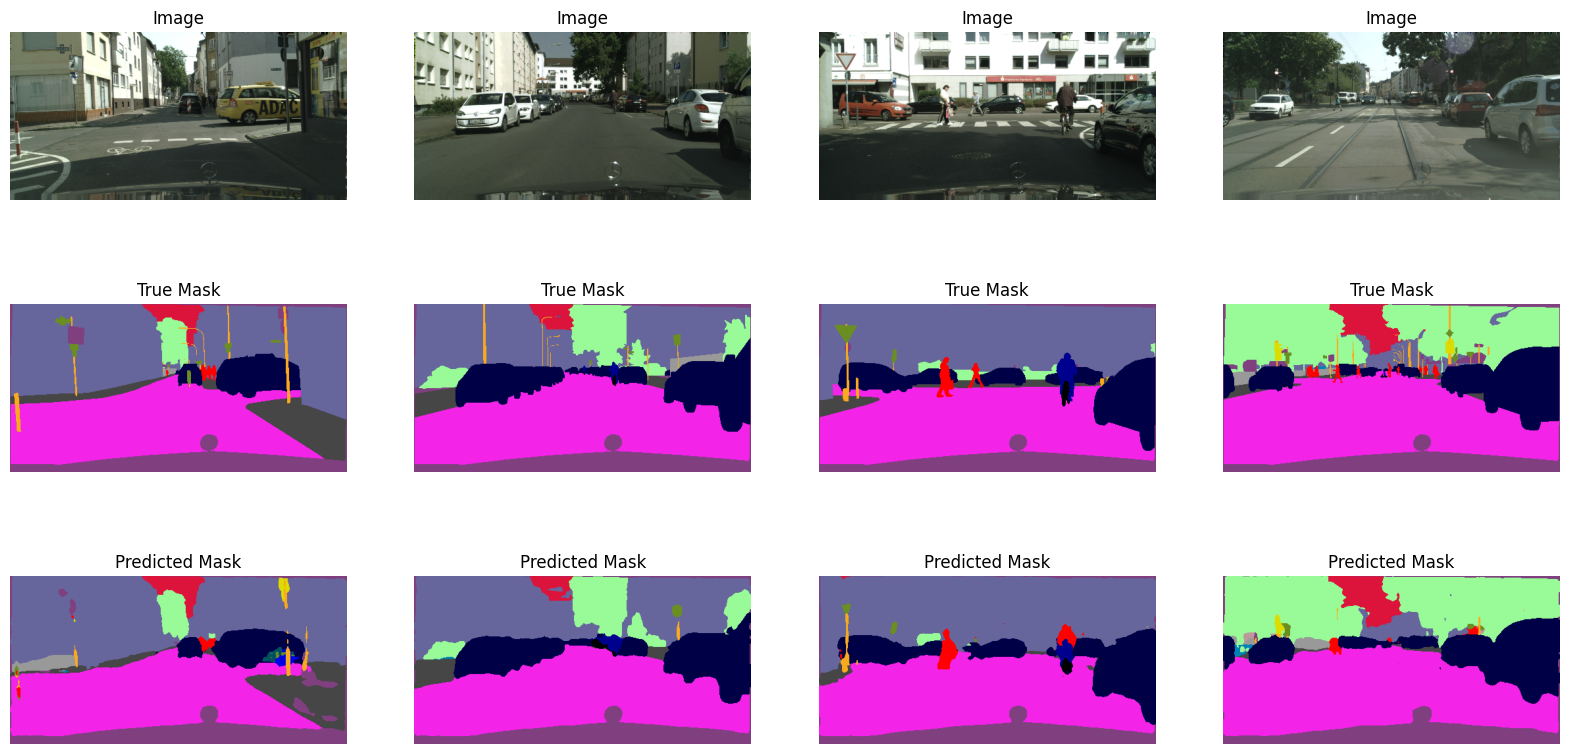

In [54]:

def plot_predictions(model, dataset, colormap, num_images=4):
    dataset_iter = iter(dataset)
    images, masks = next(dataset_iter)
    predictions = model.predict(images)

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Plot original image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
        plt.title('Image')

        # Plot true mask in color
        true_mask = np.squeeze(masks[i].numpy())
        true_mask_rgb = decode_segmentation_mask(true_mask, colormap)
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(true_mask_rgb)
        plt.axis('off')
        plt.title('True Mask')

        # Plot predicted mask in color
        pred_mask = np.argmax(predictions[i], axis=-1)
        pred_mask_rgb = decode_segmentation_mask(pred_mask, colormap)
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(pred_mask_rgb)
        plt.axis('off')
        plt.title('Predicted Mask')

    plt.show()

# Plot predictions on validation dataset
plot_predictions(model, val_dataset, colormap)


Black and White Prediction

1/1 [==============================] - 0s 42ms/step


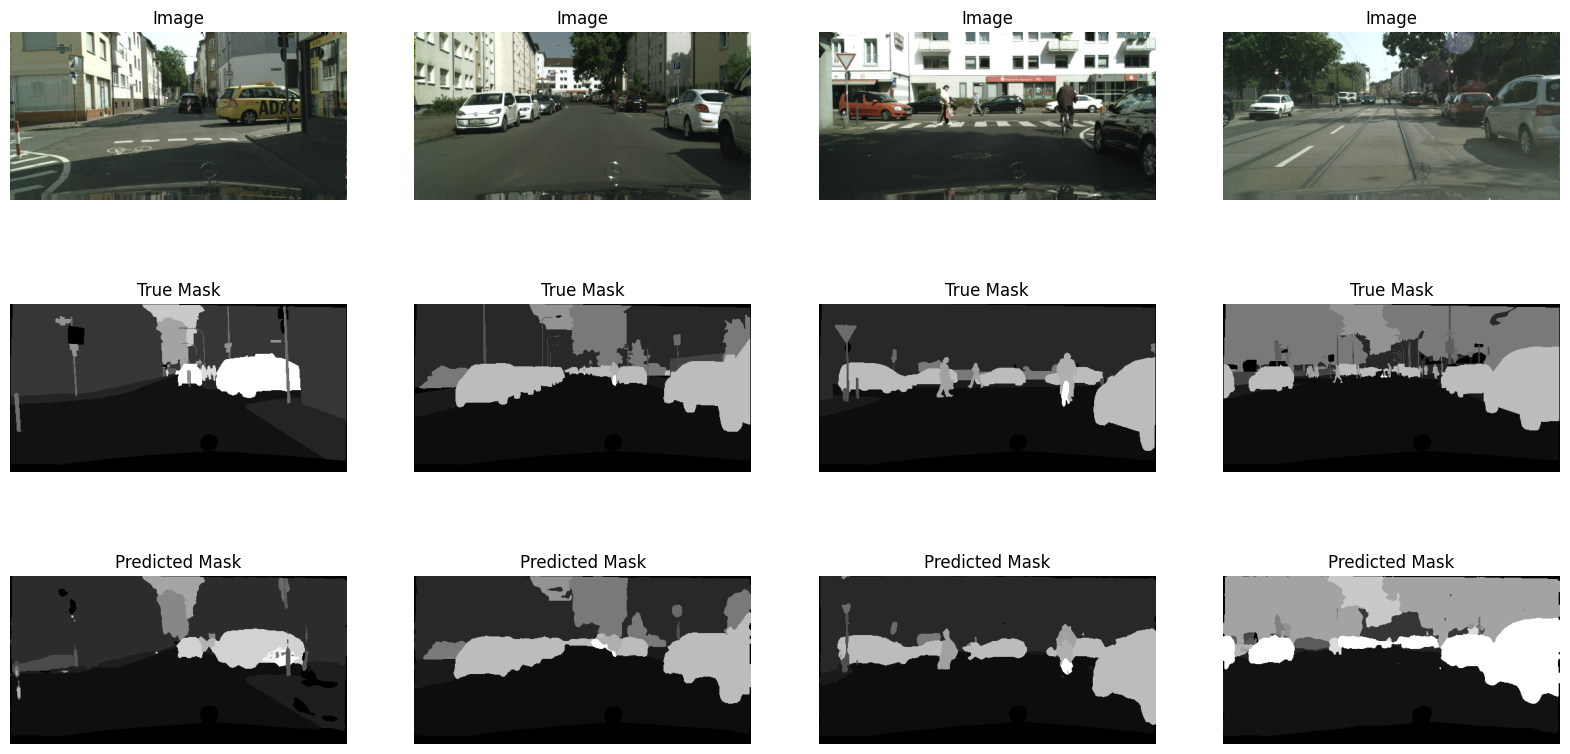

In [55]:
def plot_predictions(model, dataset, num_images=4):
    images, masks = next(iter(dataset.take(1)))
    predictions = model.predict(images)

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Plot original image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
        plt.title('Image')

        # Plot true mask
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(np.squeeze(masks[i].numpy()), cmap='gray')
        plt.axis('off')
        plt.title('True Mask')

        # Plot predicted mask
        pred_mask = np.argmax(predictions[i], axis=-1)
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')
        plt.title('Predicted Mask')

    plt.show()

# Evaluate the model on the test dataset
# test_loss, test_accuracy = model.evaluate(test_dataset)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")

# Plot predictions on test dataset
plot_predictions(model, val_dataset)